In [1]:
import ROOT
import numpy as np
import time
from scipy.integrate import quad
import scipy.signal as signal

import matplotlib.pyplot as plt

%matplotlib inline

Welcome to JupyROOT 6.18/02


Primero se definirán las funciones a utilizar

In [2]:
def Landau(x,u=0,c=100):
        I = ROOT.TMath.Landau(x,u,c, True)
    
        if I ==0:
            return 1e-7
        else:
            return I
        
def metropolis(n,P,i,f, args, histogram):
    
    u, c = args
    phi = np.random.random()*(f-i) + i
    counter = 0
    start = time.time()
    while counter < n:
        phi_p = np.random.random()*(f-i) + i
        
        DS = -np.log(P(phi_p,u,c)/P(phi,u,c))
    
        if DS < 0:
            phi = phi_p
            histogram.Fill(phi_p)
            counter += 1

        elif DS > 0:
            p = P(phi_p,u,c)/P(phi,u,c)
            if p > np.random.random():
                phi = phi_p
                histogram.Fill(phi_p)
                counter += 1

        else:
            continue

#         if counter%10000== 0:
#             print(counter, time.time() - start)

def chi_sqrd_calc(u_mesh, c_mesh):
    
    histograms = []
    hist_dftn = lambda u_n, c_n: "hist_{}_{}".format(u_n,c_n) #histogram default name
    for i in u_mesh[0,:]:
        for j in c_mesh[:,0]:
            #print("hola1")
            #histograms[hist_dftn(i,j)] = ROOT.TH1F(hist_dftn(i,j), 'Metrop u = {}, c = {}'.format(i,j), 200, 0, 1500 )
            histograms.append(ROOT.TH1F(hist_dftn(i,j), 'Metrop u = {}, c = {}'.format(i,j), 200, 50, 1500 ))
            
            metropolis(N, Landau, 50,1500, (i,j), histograms[-1])
           
    Chi2 = []
    for hist in histograms:
        chi2 = 0.0
       # print("hola2")
        for j in range(hist2_x.GetNbinsX() + 1):
            if hist2_x.GetBinContent(j) != 0:
                chi2 += ((hist2_x.GetBinContent(j) - hist.GetBinContent(j))**2) / hist2_x.GetBinContent(j)
                
        Chi2.append(chi2)
        
    return np.array(Chi2)

# Tarea 1: 

## Leyendo los datos y generando histogramas

In [3]:
c1 = ROOT.TCanvas("c1", "Data_tree", 200,10,700,900) #Creating the Canvas
c1.SetFillColor(18)


In [4]:
#Reading the data
DataChain = ROOT.TChain("SystemTree;1")
DataChain.Add("N1017248532.root")

hist_x = ROOT.TH1F('full_data', 'Full Histogram',200,0,3500e3)
hist2_x = ROOT.TH1F('cut_data', 'Reduced Histogram', 200, 50, 1500 )

for entry in DataChain:
    hist_x.Fill(entry.x) #Filling the histogram
    if 50 < entry.x < 1500:
        hist2_x.Fill(entry.x) #Cutting the data that will be used

N = hist2_x.GetEntries()

print("El porcentaje de datos a utilizar traes el corte es el {:.2f}% de los datos originales".format( \
                                        hist2_x.GetEntries()/hist_x.GetEntries()*100))

N

El porcentaje de datos a utilizar traes el corte es el 98.71% de los datos originales


83904.0

Ahora veamos por qué se decidió recortar el histograma en un número reducido de datos. Para ello veamos el histograma que contiene todos los datos

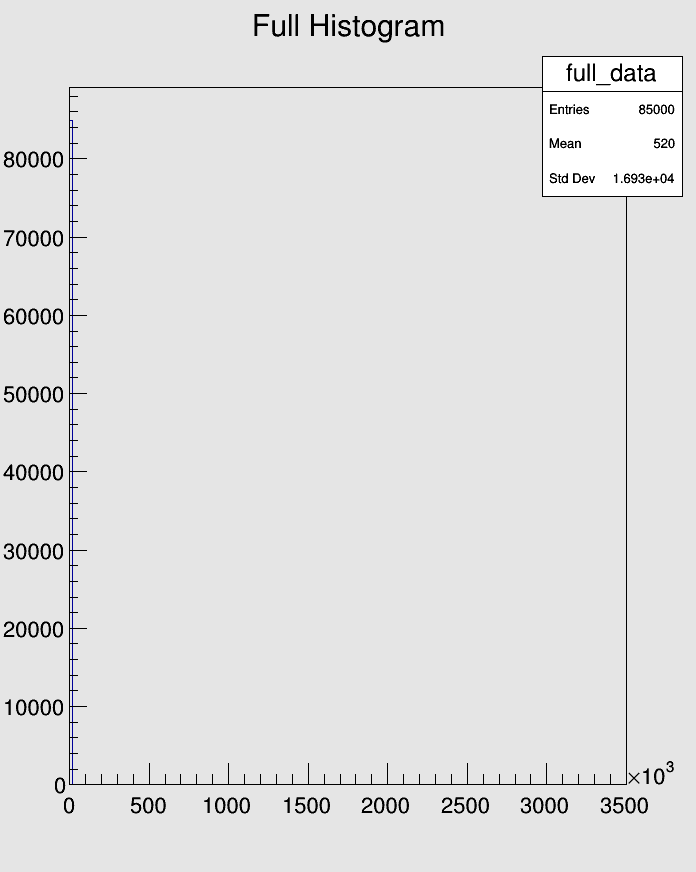

In [5]:
hist_x.Draw()
c1.Update()

ROOT.gROOT.GetListOfCanvases().Draw()

Aparentemente no hay nada en la gráfica, sin embargo lo que ocurre es que hay muchos valores en un intervalo muy pequeño. Veamos que pasa cuando se hace el histograma, pero ahora entre 0 y 1500

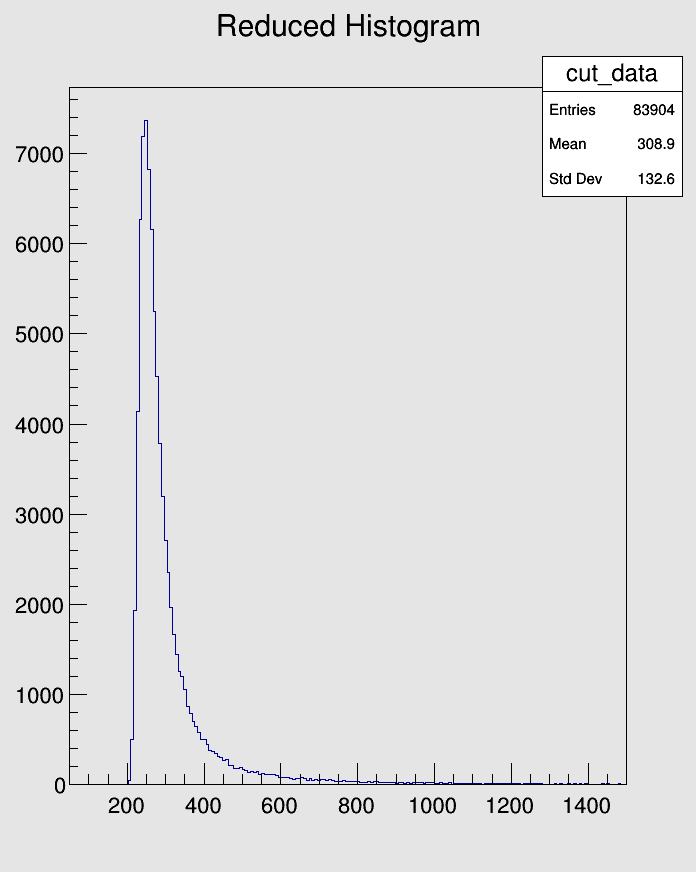

In [6]:
hist2_x.Draw()
c1.Update()

ROOT.gROOT.GetListOfCanvases().Draw()

Esto hace posible visualizar más claramente la función de densidad de probabilidad de Landau. Y reducir el tiempo de cálculo del método de metrópolis. Pues si bien se está creando un set de datos pesados por una función de probabilidad, cuando se usa el intervalo original $[200, 3500e3]$ cada uno de estos valores tiene la misma probabilidad de ser generado, sin embargo para valores >1500 la probabilidad de aparecer es casi nula, haciendo que el método de metrópolis tarde demasiado.

# Tarea 2:
## Generando Datos con Metrópolis

Se va a generar un set de datos usando el método de metrópolis para valores arbitrarios de u y c. 

En este caso u = 225 y c = 5

11.4367659092


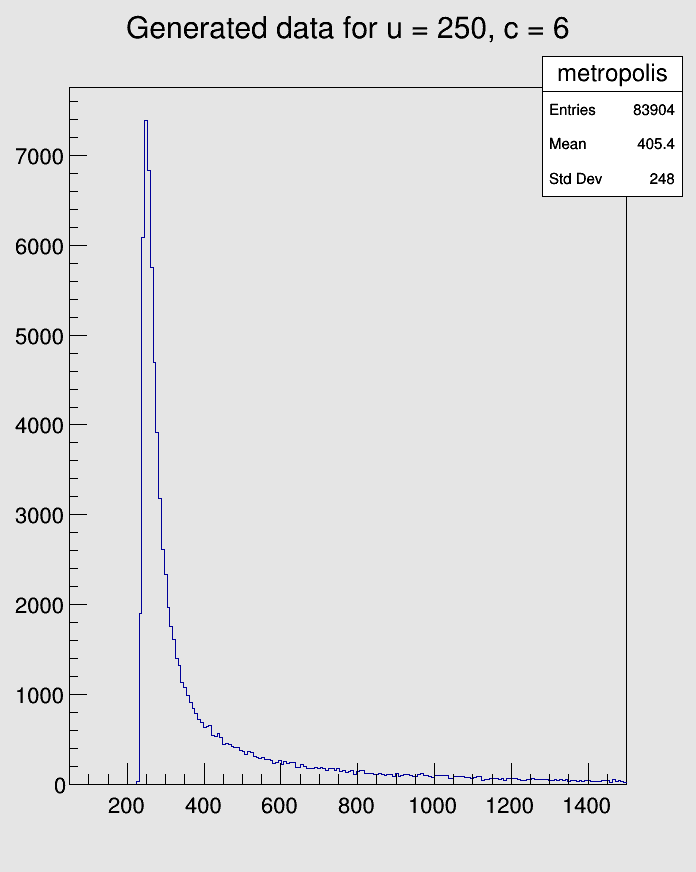

In [7]:
U, C = 250, 6
hist_metrop = ROOT.TH1F('metropolis', 'Generated data for u = {}, c = {}'.format(U,C),200,50,1500)

start = time.time()
metropolis(N,Landau,50,1500,(U,C), hist_metrop)
print(time.time() - start)

hist_metrop.Draw()
c1.Update()

ROOT.gROOT.GetListOfCanvases().Draw()

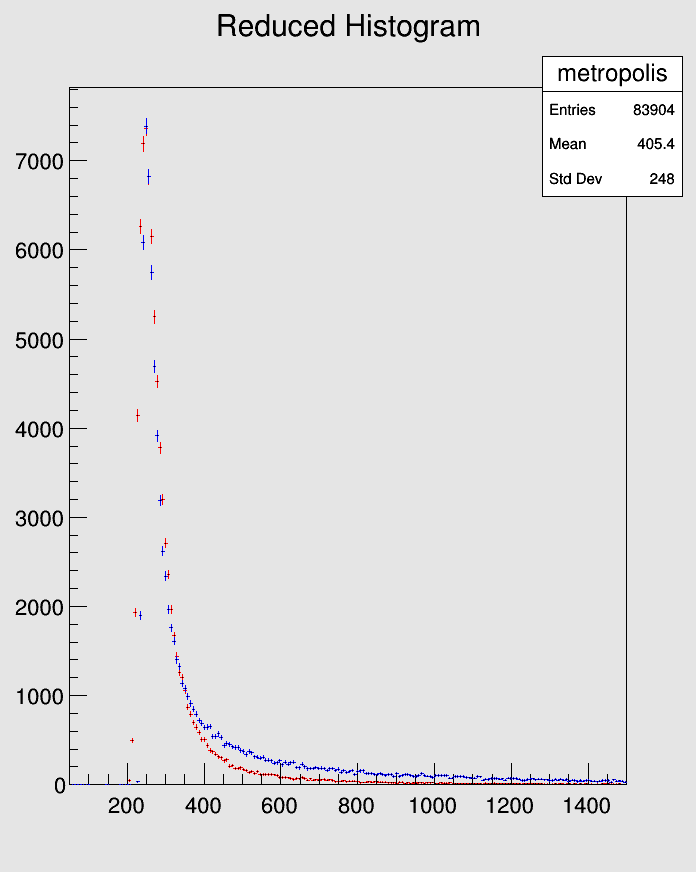

In [8]:
hist2_x.Draw("E") #Roja
hist2_x.SetLineColor(2) 


hist_metrop.Draw("E same") #Azul
hist_metrop.SetLineColor(4)

c1.Update()

ROOT.gROOT.GetListOfCanvases().Draw()

# Tarea 3:
## Encontrando los mejores valores para u y c

Tras hacer varias pruebas para ver cuáles parámetros daban el mejor fit se llego a los intervalos $[250,251]$ para u y $[6,6.2]$ para c.

Finalmente se hará una gráfica de $\chi ^2$ vs c y u e intentar encontrar los mínimos locales del gráfico (esto se justificará en el txt)

In [9]:
#Esta celda se demora unos 3min corriendo, 

U = np.linspace(250,251, 4)
C = np.linspace(6,6.2, 4)

U_mesh, C_mesh = np.meshgrid(U,C)

Chi2_Z = chi_sqrd_calc(U_mesh,C_mesh)

In [10]:
print("El valor mínimo de chi-cuadrado fue {:.2f}, y corresponde a los valores u = {:.1f}, c = {:.2f}".format(min(Chi2_Z/200), U[0], C[2]))

El valor mínimo de chi-cuadrado fue 238.01, y corresponde a los valores u = 250.0, c = 6.13


Con el objetivo de tener una mejor visualización de esto, se hace el siguiente gráfico de calor.

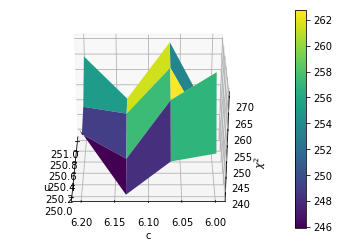

In [12]:
from mpl_toolkits import mplot3d
fig = plt.figure()

ax = plt.axes(projection='3d')
cs = ax.plot_surface(U_mesh, C_mesh, Chi2_Z.reshape(4,4).T/200, cmap = "viridis")
ax.set_xlabel('u')
ax.set_ylabel('c')
ax.set_zlabel(r'$\chi ^2$');
ax.view_init(30,180)

cbar = fig.colorbar(cs)

Dónde puede verse claramente como chi-cuadrado converge al mínimo encontrado

Finalmente, se presenta el fit del histograma original (linea roja) con los datos generados por metrópolis (linea azul).

Warning in <TROOT::Append>: Replacing existing TH1: metropolis (Potential memory leak).


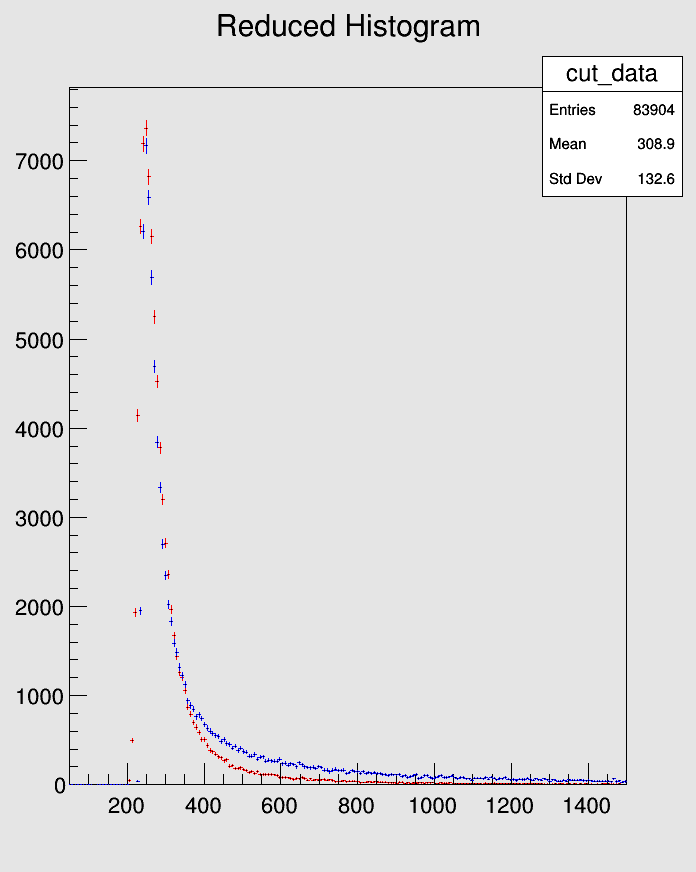

In [13]:
U_m, C_m = 250, 6.13
hist_metrop = ROOT.TH1F('metropolis', 'Generated data for u = {}, c = {}'.format(U,C),200,50,1500)

start = time.time()
metropolis(N,Landau,50,1500,(U_m,C_m), hist_metrop)

hist2_x.Draw("E") #Roja
hist2_x.SetLineColor(2) 

hist_metrop.Draw("E same") #Azul
hist_metrop.SetLineColor(4)

c1.Update()

ROOT.gROOT.GetListOfCanvases().Draw()